# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

## Calibrating and synthetic simulation of single-site Rainfall with the NSRPM.

In this script we calibrate the NSRPM (Neyman Scott Rectangular Pulse Model) using two rainfall series with different rainfall regimes: one with daily data located in the north of Spain, on a temperate climate (Cfb), and other with hourly data located in New Mexico (USA) on a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other applications.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

<font color='red'>Please, be advised that some of the processes may take up to 5 minutes in a modern computer.</font>

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from NEOPRENE.NSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.NSRP.Calibration import Calibration
from NEOPRENE.NSRP.Statistics import Statistics
from NEOPRENE.NSRP.Simulation import Simulation
from NEOPRENE.NSRP.Analysis import Analysis

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Example 1. Calibration and validation of daily data

### Loading daily rainfall data for daily data point

In [5]:
Serie_PD = pd.read_csv('auxiliary-materials/Point_Daily.csv', sep=";", decimal=".", index_col=0, parse_dates=True)
Serie_PD[Serie_PD.values<0] = np.nan
Input_Serie = pd.DataFrame(index=Serie_PD.index)
Input_Serie['Rain'] = Serie_PD.values

### Plotting daily data and seasonality

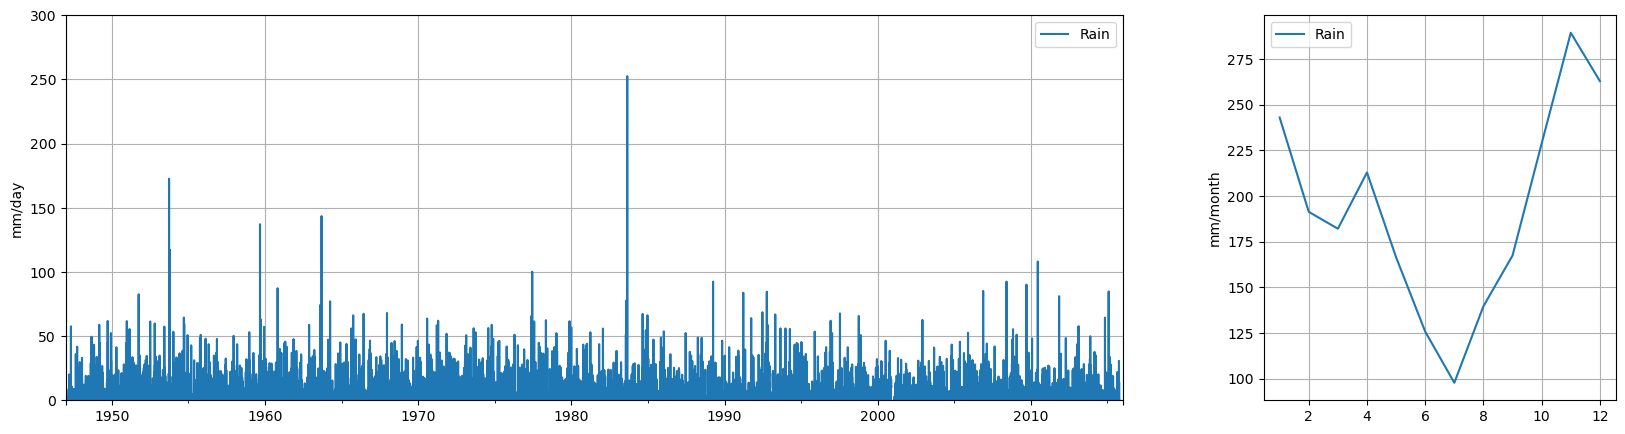

In [6]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0])
t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum = grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month');

### Calibration

The calibration input file ([Input_Cal_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_PD.yml)) contains the hyperparameters to calibrate the model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.NSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_PD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [7]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_PD.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [8]:
# Input statistics calculated from a Rainfall serie
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_PD.csv')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [9]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)
#CAL2             = CAL(statistics_model_2, verbose=False)

os.makedirs('./POINT_DAILY/CAL1/',exist_ok=True)

CAL1.save_files('./POINT_DAILY/CAL1/')
#CAL2.save_files('./CAL2/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




In [10]:
CAL1.Fitted_parameters

,1,2,3,4,5,6,7,8,9,10,11,12
landa,0.186838,0.106072,0.134552,0.169321,0.153579,0.200103,0.066762,0.024,0.078666,0.130024,0.134631,0.139132
ipsilon,8.820541,22.80319,9.265344,7.239729,6.895408,2.29869,12.954094,26.127784,6.819196,7.279068,14.656202,13.267257
eta,33.113746,57.523702,35.474572,28.05939,32.074639,17.721151,44.092898,23.154047,15.76943,20.518928,32.985533,34.367532
xi,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012
betha,0.48,0.48,0.665123,0.48,0.736981,0.820765,1.512528,1.220914,1.497636,0.48,0.48,0.48


### Simulation

The input simulation file ([Input_Sim_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_PD.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_PD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [11]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_PD.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [12]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
SIM1             = SIM(params_cal = CAL1)

# Input parameters from a dataframe

os.makedirs('./POINT_DAILY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_DAILY/SIM1/')

#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')
#SIM2.save_files('./SIM1/')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation =        94216.13
Total cumulative rainfall -             Simulated =        93764.74


## Analysis of results
In this section, an analysis of the results is made. 

In [13]:
Analysis_results = Analysis(CAL1,SIM1)

### Verification

The curve of exceedence probabilities is shown to evaluate the quality of the fit of the simulations and the observations

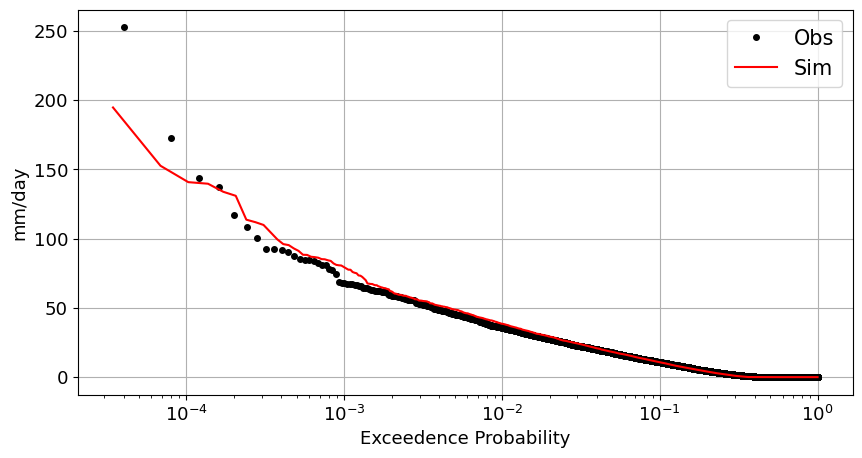

In [14]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Serie, SIM1.Daily_Simulation)

### Validation

Another set of verification plots is generated where the value of different observed statistics (dashed line) is compared against the fitted statistics (blue squares), that is, the best values of the statistic that the optimal parameters were able to reproduce, and against the simulated statistics (red triangles), the values of the statistics that were obtained when simulating synthetic time series with the calibrated parameters.

The model correctly reproduces those parameters for which it is calibrated. Those parameters that do not participate in the calibration procedure may exhibit a more erratic behavior, thus the differences between the calibrated and simulated values of the statistics.

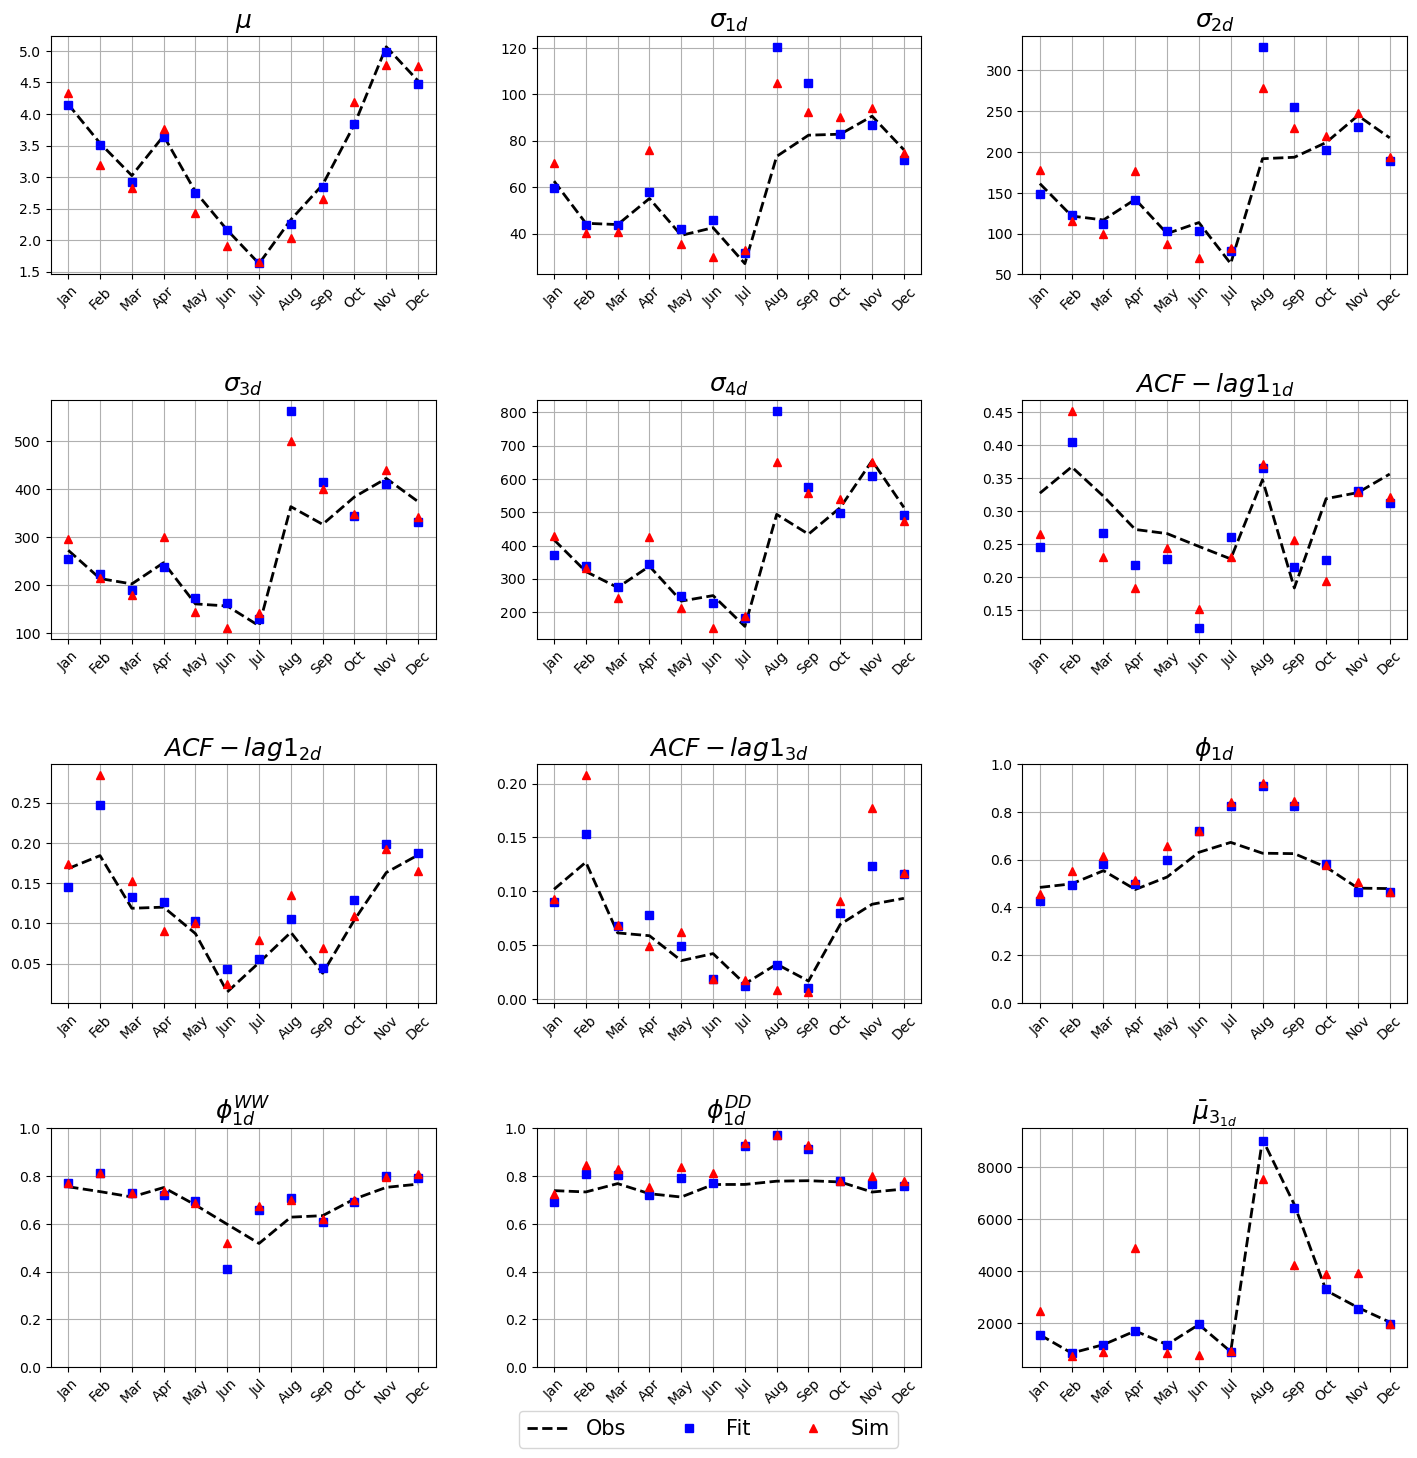

In [15]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

# Example 2. Disaggregation of daily data to hourly data

Disaggregation process might take some minutes to dissagregate several decades of data. Here we select only 5 year as an example

In [16]:
# Period selected from the input (onserved) serie
year1 = 2000; year2 = 2005
x_series = Input_Serie[(Input_Serie.index.year >= year1) & (Input_Serie.index.year < year2)]

In [17]:
# Defining hourly synthetic serie
y_series = SIM1.Hourly_Simulation.copy()

In [18]:
# Daily-to-hourly disaggregation
Analysis_results.disaggregate_rainfall(x_series, y_series)
hourly_disaggregation = Analysis_results.hourly_disaggregation

In [19]:
# Resampling hourly disaggregated serie to daily one. 
#The series is resampled through groupby to avoid possible problems when dates are greater than 2262 and less than 1677.
daily_disaggregation = pd.DataFrame(hourly_disaggregation.groupby([(hourly_disaggregation.index.year),
                                                                   (hourly_disaggregation.index.month),
                                                                   (hourly_disaggregation.index.day)]).sum().values,
                                    index=pd.period_range(start=hourly_disaggregation.index[0],end=hourly_disaggregation.index[-1],freq='D'),columns=['Rain'])
# Calculating statistics from the disaggregated daily resample serie and for the period selected from the Input serie
statistics_model_3 = Statistics(hiper_params_cal, time_series = x_series)
statistics_disaggregated = Statistics(hiper_params_cal, time_series = daily_disaggregation)

In [20]:
# Comparing daily observed statiscis with dialy dissagregated ones

statistics_model_3.statististics_dataframe.compare(statistics_disaggregated.statististics_dataframe)

1                       2                       3  \
                    self       other        self       other        self   
mean            3.507258    2.795079    2.702817    2.706961    2.089677   
var_1          41.278254   34.870696   26.169006   26.446079   24.566345   
var_2         119.565434   93.474605   66.536588    66.95141   63.601981   
var_3         215.945334  194.974498  131.377066  133.172561   94.772822   
var_4         298.109802  287.184297  145.907932  146.191298  153.684076   
autocorr_1_1     0.39951    0.429575    0.405202    0.403503    0.259598   
autocorr_2_1     0.19412    0.243148    0.173018    0.170462    0.092012   
autocorr_3_1    0.140389    0.188743    0.029453    0.026891   -0.007084   
fih_1           0.516129    0.612903         NaN         NaN         0.6   
fiWW_1              0.75        0.75    0.632353    0.676471    0.629032   
fiDD_1          0.765625    0.842105    0.662162    0.702703    0.752688   
M3_1          632.177191  571.928276  331.922783  344.862781  417.915617   

                                   4                       5              ...  \
                   other        self       other        self       other  ...   
mean            2.083368        2.91    2.922308    2.270323    2.276674  ...   
var_1          24.496333   31.787167   31.975237     25.8257   26.096314  ...   
var_2          63.342758   82.352267   83.717381   77.780251   79.071018  ...   
var_3          94.472236    114.2329  115.742526  148.364508  148.929216  ...   
var_4         152.658578  196.617458  200.963522  251.422288  255.886979  ...   
autocorr_1_1    0.257947    0.245841    0.254274    0.431689    0.434951  ...   
autocorr_2_1    0.092303    0.046585    0.048914    0.216869    0.216901  ...   
autocorr_3_1   -0.006448   -0.010978   -0.011483   -0.036449    -0.03184  ...   
fih_1           0.606452    0.433333        0.46    0.587097    0.580645  ...   
fiWW_1          0.655738    0.776471    0.716049    0.609375    0.630769  ...   
fiDD_1          0.776596    0.707692    0.666667    0.725275    0.733333  ...   
M3_1          416.319744  552.230324  554.290921  409.973966  417.076075  ...   

                       8                       9                      10  \
                    self       other        self       other        self   
mean            1.465161    1.464055    1.595333    1.595433    3.713548   
var_1          14.645625   14.651263   24.285778   24.275701   48.780268   
var_2          40.120764   39.911175   49.032313   48.928522  116.462913   
var_3          69.314508   69.217197   78.142004   78.683195  192.214822   
var_4          95.344339   95.106619   83.931309    84.38681  266.877291   
autocorr_1_1    0.250708    0.247591   -0.001251    0.001448    0.207701   
autocorr_2_1    0.234899    0.237813   -0.036542   -0.036321    0.042307   
autocorr_3_1    0.174173    0.173053    -0.03413   -0.034624   -0.026483   
fih_1            0.63871    0.658065    0.673333        0.66    0.496774   
fiWW_1          0.696429    0.622642     0.55102    0.607843    0.705128   
fiDD_1          0.828283    0.803922    0.782178     0.79798    0.701299   
M3_1          242.032888  241.300217  648.894994  648.046664  841.705477   

                                   11                       12               
                   other         self       other         self        other  
mean            3.714222     4.966187    4.610027     5.054032     4.002728  
var_1          48.713324    64.706555   61.243869   101.595064    82.012184  
var_2         116.271855   180.721227  117.945854   300.214935   255.028024  
var_3          192.60825   216.536007  206.476774   496.819303   476.243876  
var_4         267.377147   331.735478   223.60423   896.459417   591.057604  
autocorr_1_1    0.208462     0.172506    0.199839     0.508178      0.53266  
autocorr_2_1    0.043478    -0.099715   -0.065872     0.320199     0.353639  
autocorr_3_1   -0.026212    -0.096403   -0.062661     0.

In [21]:
hourly_disaggregation.head()

,Rain
2000-01-01 00:00:00,NaN
2000-01-01 01:00:00,NaN
2000-01-01 02:00:00,NaN
2000-01-01 03:00:00,NaN
2000-01-01 04:00:00,NaN


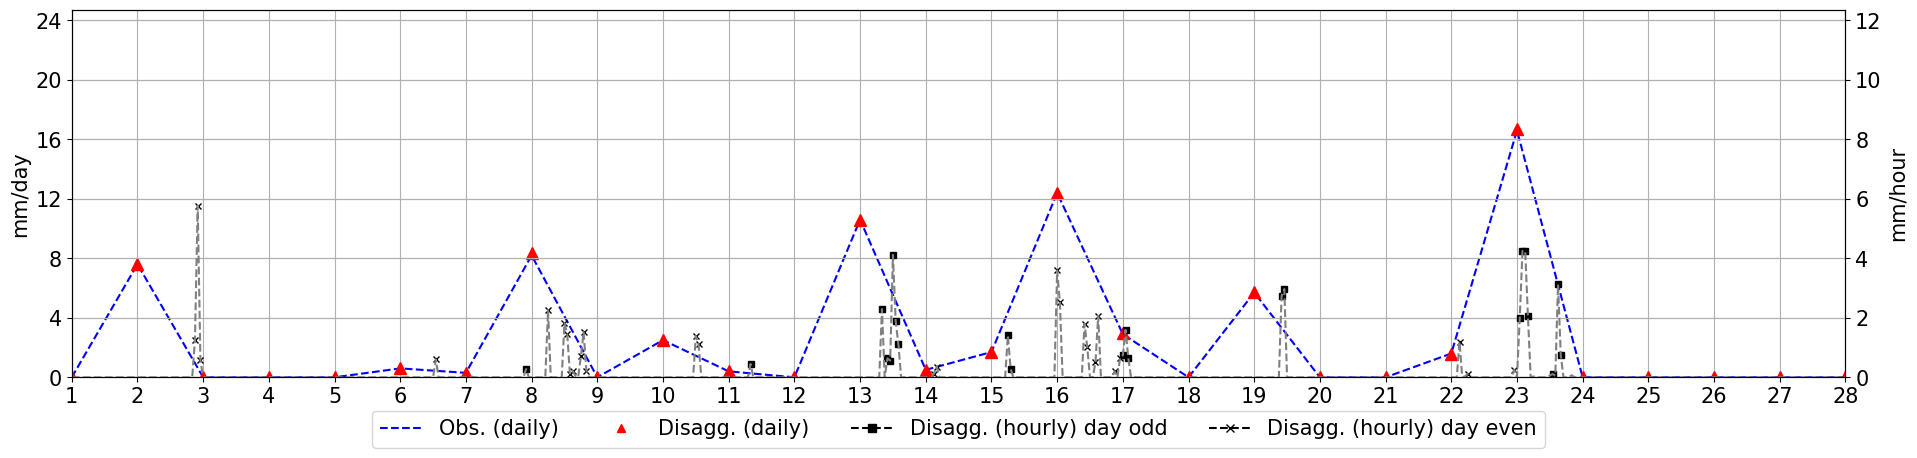

In [22]:
Analysis_results.disaggregation_fig(hourly_disaggregation,daily_disaggregation,x_series,year1,year1)

### Save Figures
To save the figures in png format we execute the following line

In [23]:
Analysis_results.save_figures('./POINT_DAILY/Figures/')

# Example 3. Calibration and Simulation of hourly data

### Loading hourly rainfall data for hourly data point

In [24]:
Serie_PH=pd.read_csv('auxiliary-materials/Point_Hourly.csv', sep=",", decimal=".", index_col=0, parse_dates = True)
Serie_PH[Serie_PH.values<0]=np.nan
Input_Serie=pd.DataFrame(index=Serie_PH.index)
Input_Serie['Rain']=Serie_PH.values

### Plotting hourly data and seasonality

Text(0, 0.5, 'mm/month')

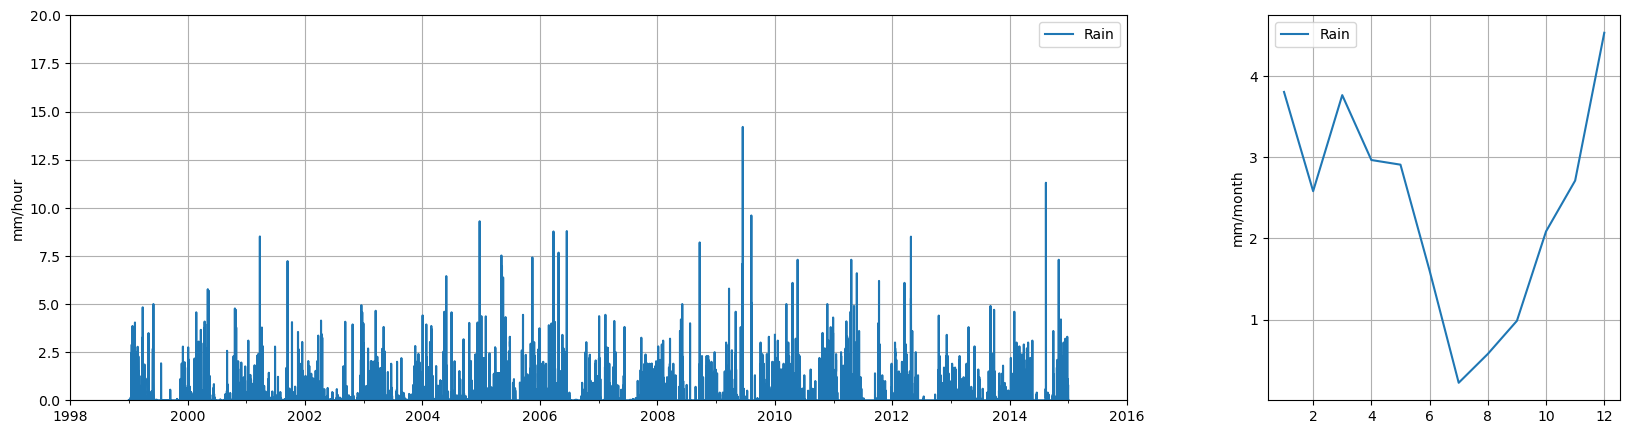

In [25]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0]); t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 20), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/hour')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Calibration

In [26]:
hiper_params_cal = Calhps('./Input_Cal_PH.yml')
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

In [27]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)

os.makedirs('./POINT_HOURLY/CAL1/', exist_ok=True)

CAL1.save_files('./POINT_HOURLY/CAL1/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




### Simulation

In [28]:
hiper_params_sim = Simhps('./Input_Sim_PH.yml')

SIM              = Simulation(hiper_params_sim) 
SIM1             = SIM(params_cal = CAL1)
#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation - Storm 1 =         1185.63
Total cumulative rainfall - Analytical estimation - Storm 2 =         1138.27
Total cumulative rainfall - Analytical estimation =         2323.90
Total cumulative rainfall -             Simulated =         2084.15


In [29]:
os.makedirs('./POINT_HOURLY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_HOURLY/SIM1/')

## Analysis of results
In this section, an analysis of the results is made. 

In [30]:
Analysis_results = Analysis(CAL1,SIM1)

### Validation

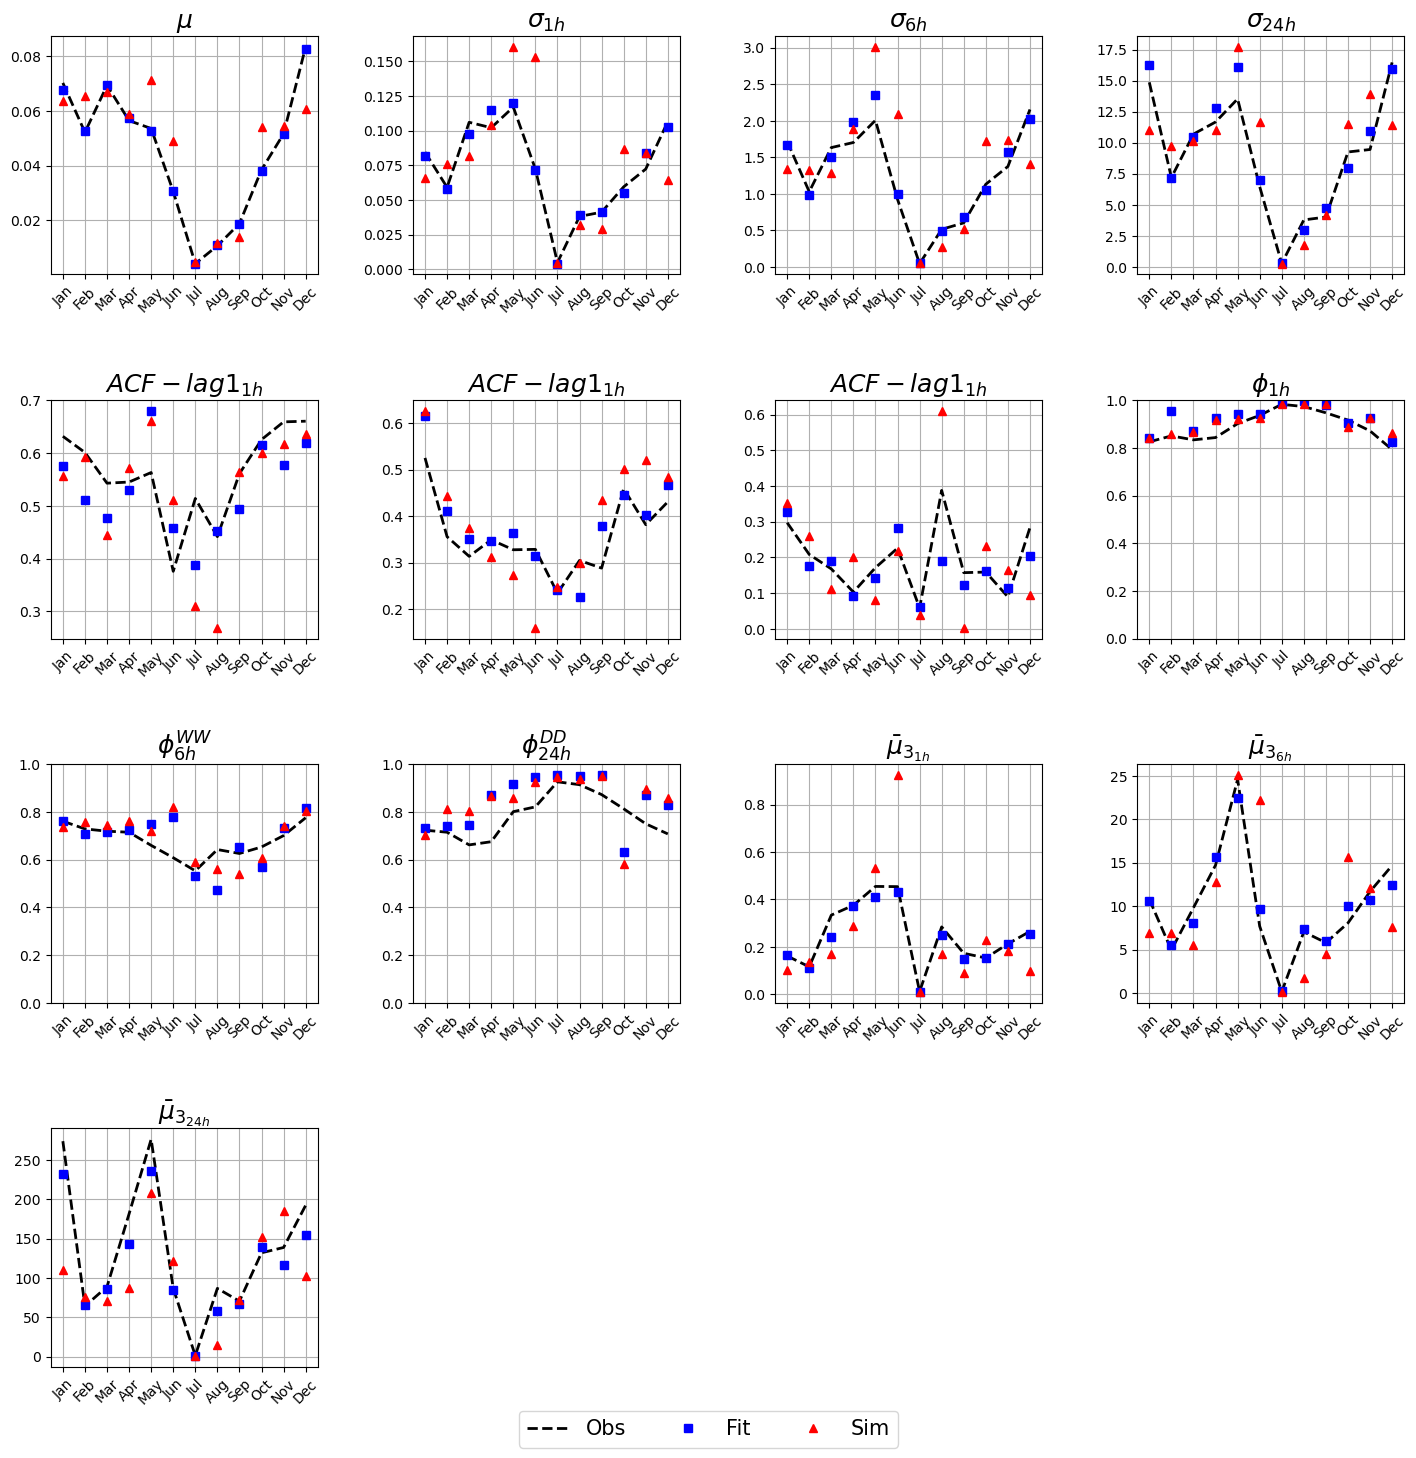

In [31]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

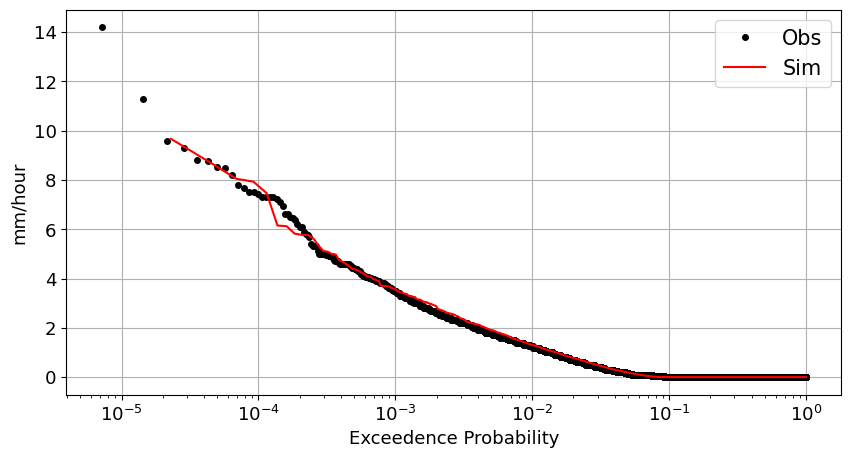

In [32]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Serie, SIM1.Hourly_Simulation)

### Save Figures
To save the figures in png format we execute the following line

In [33]:
Analysis_results.save_figures('./POINT_HOURLY/Figures/')

# Session info

In [34]:
!conda list

# packages in environment at /home/manuel/miniforge3/envs/NEOPRENE:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alsa-lib                  1.2.10               hd590300_0    conda-forge
asttokens                 2.4.0              pyhd8ed1ab_0    conda-forge
attr                      2.5.1                h166bdaf_1    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.5              pyhd8ed1ab_0    conda-forge
brotli                    1.1.0                hd590300_1    conda-forge
brotli-bin                1.1.0                hd590300_1    conda-forge
bzip2                     1.0.8                h7f98852_4    conda-forge
ca-certificates           2023.7.22            hbcca054_